<a href="https://colab.research.google.com/github/gabrie1-s/Chagas_analysis/blob/lstm/NACA_data_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Version: for_LSTM_2.0.0

In [41]:
%%capture
!pip install neptune-notebooks

In [42]:
%%capture
!jupyter nbextension enable --py neptune-notebooks

In [43]:
!mkdir dataset

mkdir: cannot create directory ‘dataset’: File exists


In [44]:
%%capture
!pip install neptune-client

In [45]:
import keras
import pdb
import gc
import requests

In [46]:
%%capture
!pip install --upgrade pip
!pip install mat73
!pip install scikit-learn --upgrade
!pip install scipy
!pip install Bayesian-Optimization
!pip install fpdf

In [47]:
from google.colab import drive
import mat73
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import statistics as st
import cv2

In [48]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
%cd /content/drive/MyDrive/CNN_Chagas/Chagas/LSTM

/content/drive/MyDrive/CNN_Chagas/Chagas/LSTM


In [81]:
import neptune.new as neptune

run = neptune.init_run(
    project="gabrie1-s/NACA-data-extraction",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI1ODlmNWY4ZS0zNmUzLTQ3NWQtYmVkYy05ZmUyMDM4ZGQxMzkifQ==",
    description='''Aplicamos o NACA para eliminar batimentos cujo valor do S/R < 15.
    Consideramos 3 batimentos por sinal.Não adotamos o procedimento de shifting.
    Comparamos cada batimento médio do sinal (3 batimentos) com o batimento dmédio
    do sinal anterior por meio da DTW. Eliminamos os batimentos cujo valor da DTW
    era menor que 0.25.''',
    source_files=["NACA_data_extraction.ipynb"],
)  # your credentials

<ipython-input-81-d17d253f0e00>:3: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/gabrie1-s/NACA-data-extraction/e/NAC-22


In [82]:
%cd -

/content


In [83]:
run["code_version"] = "for_LSTM_2.0.0"

In [53]:
dataset = mat73.loadmat('/content/drive/MyDrive/CNN_Chagas/Chagas/data/Dataset_Raw.mat')

In [54]:
signals = list(dataset['Dataset_Raw'])

output = []
for i in range(0, len(signals)):
    output.append(signals[i][-1])
    signals[i] = np.delete(signals[i], [-1,-2])
    # signals[i] = signals[i][0:1000]

In [55]:
def discrete_ratio(ratio_set, n):
    classes = list(range(1, n+1))
    ratio = 1.0/n

    for j in range(0, len(ratio_set)):
        for i in range(0, n):
            if ratio_set[j] > ratio*i and ratio_set[j] <= ratio*(i+1):
                ratio_set[j] = int(classes[i])
                break

    return ratio_set

In [56]:
output = discrete_ratio(output, 2)

In [57]:
with open('Sinais_Chagas.txt') as f:
    lines = f.readlines()

idx = []

for i in range(0, len(lines)):
  arq = lines[i][lines[i].find('FileName1 = '):lines[i].find('\n')]
  signal = lines[i][lines[i].find('Signals{'):lines[i].find('\n')]
  signal = signal[signal.find('{')+1 : signal.find('}')]

  if arq != '':
    idx.append(arq[13:-2])
  if signal != '':
     idx.append(signal)

idx = idx[:-3]


pairs = []
for i in range(0, len(idx), 2):
  val = [idx[i+1], idx[i]]
  pairs.append(val)

In [58]:
matriz_pontos = []
for i in pairs:
    url =  str(i[1]) + '_MatrizPontos.mat'
    pontos = sio.loadmat(url)
    matriz_pontos.append(pontos["Matriz_Pontos"])

In [59]:
peaks = []
for sig in matriz_pontos:
  line = []
  for beat in sig:
    line.append(beat[4])
  peaks.append(line)

## Butterworth filter

In [60]:
from scipy.signal import butter, filtfilt

order = 2
fs = 128  # Sampling frequency
fc = 1  # Cutoff frequency
b, a = butter(order, fc, btype='high', fs=fs)

In [61]:
x = []

for signal in signals:
  filtered_signal = filtfilt(b, a, signal)
  x.append(filtered_signal)

signals = x
del x, filtered_signal

## Data Split

In [62]:
indexes = range(len(signals))

In [63]:
m_rem, m_te, x_rem, x_te, p_rem, p_te, y_rem, y_te = train_test_split(matriz_pontos, signals, peaks, output, test_size=0.15, stratify=output, random_state=38)
m_tr, m_va, x_tr, x_va, p_tr, p_va, y_tr, y_va = train_test_split(m_rem, x_rem, p_rem, y_rem, test_size=0.15, stratify=y_rem, random_state=38)

## Medium beats acquisition

In [64]:
def signals_med(array):
    array_size = len(array[0])
    array_qnt = len(array)
    md_vector = []

    for j in range(0, array_size):
        aux = []

        for i in range(0, array_qnt):
            aux.append(array[i][j])

        md_vector.append(st.median(aux))

    return md_vector

In [65]:
def shifting(signal, samples_position, beat_template, peaks):
  samples = []
  shift = 2
  for p_index, p in enumerate(samples_position):
    aux = []
    for i in range(-1*shift, shift+1):
      aux.append(mean_squared_error(beat_template, signal[p[0]+i:p[1]+i]))

    M = aux.index(min(aux)) - shift
    samples_position[p_index] = [p[0]+M, p[1]+M]
    samples.append(signal[p[0]+M : p[1]+M])
    peaks[p_index] += M


  return samples_position, samples, peaks


In [66]:
def del_var(samples, samples_position, beat_template):

    for idx, sample in enumerate(samples):
        val = 0
        for i in range (len(sample)):
            val += (sample[i] - beat_template[i])**2

        val /= len(sample)

        if val > st.variance(beat_template):
            samples.pop(idx)
            samples_position.pop(idx)

    return samples_position, samples

In [67]:
def snr(beat_template, samples):
  var = st.variance(beat_template)
  noise = []

  for sample in samples:
    n = st.variance(np.subtract(beat_template, sample))
    noise.append(n)

  sr = var/st.median(noise)
  return sr

In [68]:
def window(signal, peaks):
    #calculating L
    peaks_difference = [peaks[i+1] - peaks[i] for i in range(len(peaks)-1)]
    L = 1.1*st.median(peaks_difference)


    #obtening beat samples
    #samples position consists in an array of tuples. Each tuples contains the estimate begin and end of a beat
    samples_position = []
    samples = []

    # pdb.set_trace()
    for idx, p in enumerate(peaks):
        samples.append(signal[p-math.floor(L/3) : p+math.ceil(2*L/3)])
        samples_position.append([p-math.floor(L/3) , p+math.ceil(2*L/3)])

    beat_template = signals_med(samples)
    # samples_position, samples, peaks = shifting(signal, samples_position, beat_template, peaks)
    #samples_position, samples = del_var(samples, samples_position, beat_template)
    sr = snr(beat_template, samples)

    return sr, beat_template

In [69]:
del dataset, signal

In [70]:
bps = 3
thres = 15

In [71]:
def thres_test(signal, peaks, mp, outputs, bps):
  templates = []
  beats = []
  noise_rates = []
  y = []

  for idx, p in enumerate(peaks):
    for i in range(0, len(p)-bps, bps):
        sr, template = window(signal[idx], p[i:i+bps])

        ini = mp[idx][i][0]
        end = mp[idx][i+bps-1][-1]
        beats_t = signal[idx][ini:end]

        if sr > thres:
          beats.append(beats_t)
          templates.append(template)
          noise_rates.append(sr)
          y.append(outputs[idx])

  noise_rates = np.array(noise_rates)
  beats = np.array(beats)
  templates = np.array(templates)
  y = np.array(y)

  # arr_idxs = noise_rates.argsort()
  # noise_rates = noise_rates[arr_idxs[::-1]]
  # templates = templates[arr_idxs[::-1]]
  # y = y[arr_idxs[::-1]]

  return beats, templates, y

In [72]:
x_tr, temp_tr, y_tr = thres_test(x_tr, p_tr, m_tr, y_tr, bps)
x_va, temp_va, y_va = thres_test(x_va, p_va, m_va, y_va, bps)
x_te, temp_te, y_te = thres_test(x_te, p_te, m_te, y_te, bps)

<ipython-input-71-8e9e28426d90>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  beats = np.array(beats)
<ipython-input-71-8e9e28426d90>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  templates = np.array(templates)
<ipython-input-71-8e9e28426d90>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  beats = np.array(beats)
<ipython

In [73]:
%%capture
!pip install dtaidistance
!pip install -U ray

In [74]:
from dtaidistance import dtw
import ray
from ray.util.multiprocessing import Pool

In [75]:
def remove_similar(sigs, temp, y, limit):
  new_sigs = []
  new_y = []
  new_temp = []
  dist_norm = []

  for i in range(len(sigs)-1):
    if i == 0:
      new_sigs.append(sigs[i])
      new_y.append(y[i])
      new_temp.append(temp[i])

    else:
      # pdb.set_trace()
      a = new_sigs[-1]
      b = sigs[i]

      dist = dtw.distance_fast(a, b)
      dist_norm.append(dist/(max(len(a), len(b))))
      print(dist_norm[-1])

      if dist_norm[-1] > limit:
        new_sigs.append(sigs[i])
        new_y.append(y[i])
        new_temp.append(temp[i])

  return np.array(new_sigs), np.array(new_temp), np.array(new_y), dist_norm

In [76]:
x_t, temp_t, y_t, dist = remove_similar(x_tr, temp_tr, y_tr, 0.25)
x_v, temp_v, y_v, dist = remove_similar(x_va, temp_va, y_va, 0.25)
x_e, temp_e, y_e, dist = remove_similar(x_te, temp_te, y_te, 0.25)

A saída de streaming foi truncada nas últimas 5000 linhas.
0.30032149683555287
0.24148927642424695
0.291067652950902
0.29354233745012376
0.2499497457158147
0.28579676941068727
0.24380077916622744
0.34251767595296156
0.19131936482177636
0.3398653925557462
0.2665386396374435
0.2702688608358386
0.3128070691113649
0.27174562348201475
0.30554614360177795
0.2806571275289781
0.32261244959829455
0.2779468391170399
0.2792779540959033
0.23411868548284218
0.2730458331510456
0.32486949054738284
0.2234216007737114
0.2247769701297432
0.31736661224086243
0.27297262275274553
0.2916953625060539
0.3071002767166762
0.3176014946913697
0.3267176125440966
0.38828735173338635
0.35506990717752807
0.2614055602741448
0.3545330007349698
0.31451706678649544
0.2708621205738262
0.25362390762598086
0.2819119560008892
0.30399127671835835
0.3000351090602147
0.254478582679984
0.28359638581921587
0.3032070545922681
0.3176581836918275
0.2650740250408036
0.3255600917102961
0.23188240852915432
0.28978183726414863
0.2864618

<ipython-input-75-8d7f0472b832>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(new_sigs), np.array(new_temp), np.array(new_y), dist_norm


A saída de streaming foi truncada nas últimas 5000 linhas.
0.18556024164789606
0.18944152967439895
0.19890926923444985
0.19376405953489464
0.18703847328043158
0.19635152814033038
0.1917385374276483
0.19228486982351128
0.19784642732612973
0.1909017627331836
0.19860328550499598
0.19396109790738297
0.1971838328799561
0.18731815794791282
0.19181008314062936
0.19424040436519724
0.18473017781019646
0.19581474349797656
0.18625767298456597
0.1874843415350985
0.19055723709144298
0.18378979036233054
0.19064028155366428
0.18927924171374286
0.1871712186231072
0.19146964925290505
0.18105417860008693
0.1905522423836209
0.18327223373371465
0.18216027350193525
0.1810023392550712
0.18628653139180576
0.18646248617715694
0.1759779220564097
0.180759886969462
0.18077890214808293
0.17987840933824908
0.18942831460108422
0.18825251709663032
0.19276160542904183
0.192992200063978
0.2002516511900979
0.1937309812611417
0.19941418555264426
0.19415865464562007
0.1936087142244412
0.19788008643928182
0.20293146372072

<ipython-input-75-8d7f0472b832>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(new_sigs), np.array(new_temp), np.array(new_y), dist_norm


A saída de streaming foi truncada nas últimas 5000 linhas.
0.10299498044895533
0.12073152690762498
0.1302271886508003
0.11024778627478374
0.15569750432659357
0.14046832897067862
0.14473539365661325
0.12190047987113575
0.14187733694669308
0.14206188855991822
0.119475956195238
0.13807258944194825
0.13655992629543104
0.1355344091196437
0.12135157580045285
0.1561354584026638
0.14571408061276328
0.12912309570919822
0.942066671831252
1.1039638849927176
0.10782838501023938
0.11739145645716116
0.13163054696251297
0.13406436764352214
0.10416678329906162
0.10424311383574122
0.09532394719485299
0.13187637558632587
0.10658076510809628
0.1447259968376853
0.1186808760675311
0.13308232395214042
0.13410685297562586
0.1329100967834507
0.13043685582195336
0.12842952083316878
0.14329927843546184
0.6325395954686983
0.6281628154457269
0.16961617865748976
0.13573916316527487
0.11596482811867617
0.1055233200659258
0.16239351353744919
0.1464928997162203
0.14194591161445716
0.10733406624690484
0.13453402425906

<ipython-input-75-8d7f0472b832>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(new_sigs), np.array(new_temp), np.array(new_y), dist_norm


1


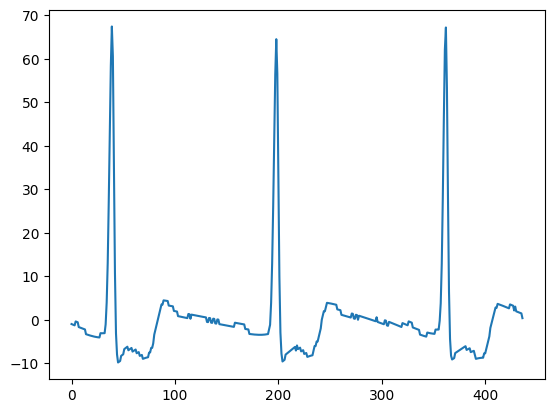

2


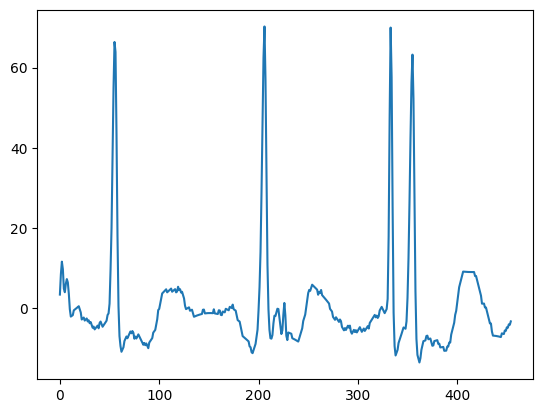

3


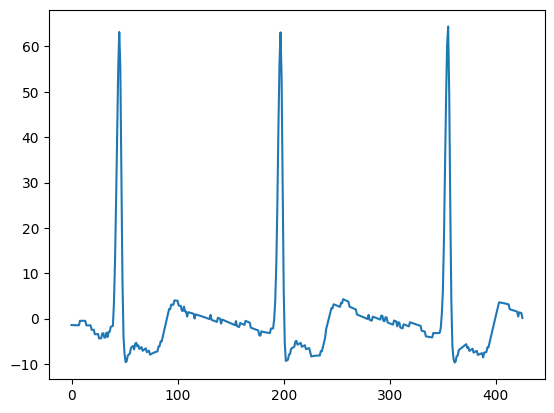

4


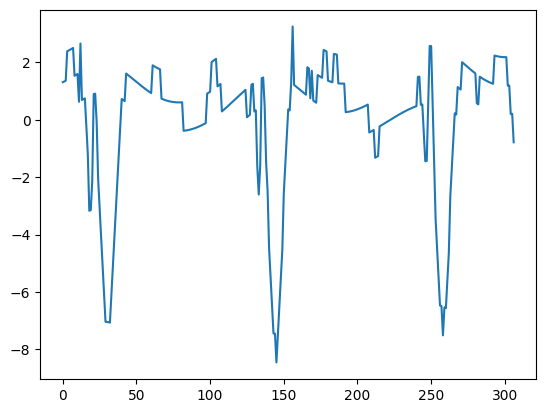

5


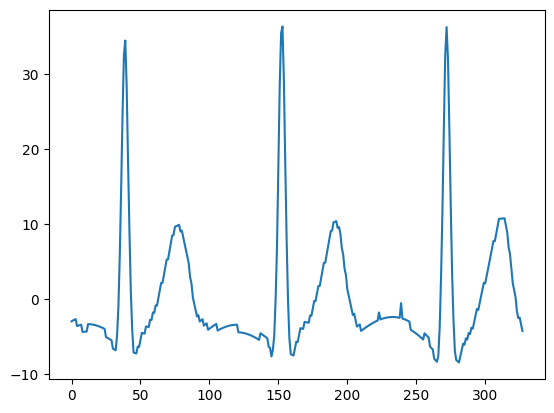

6


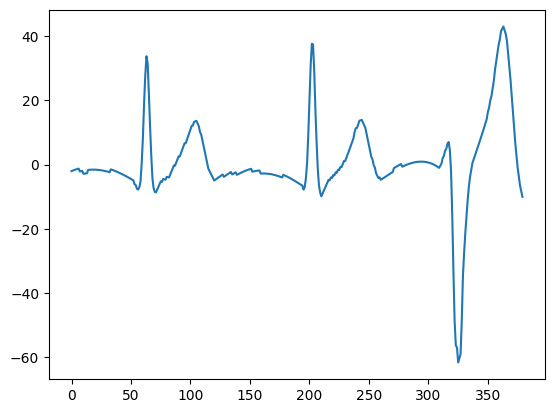

7


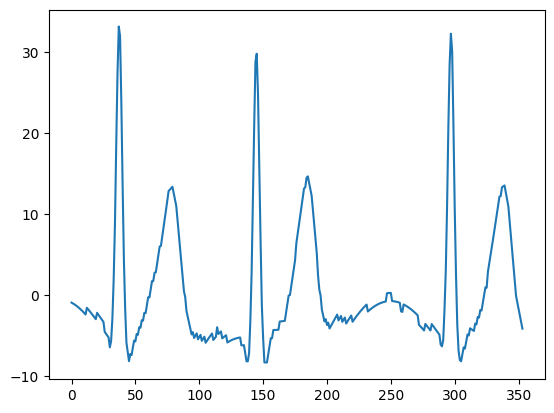

8


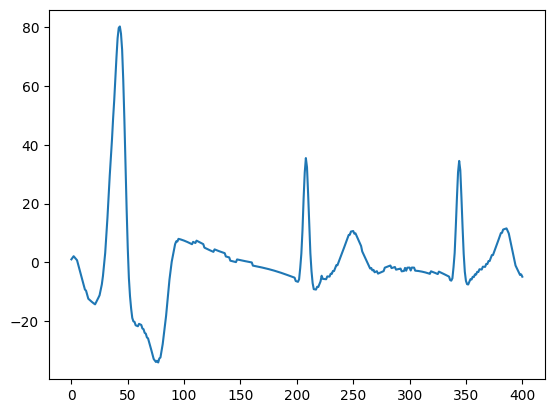

9


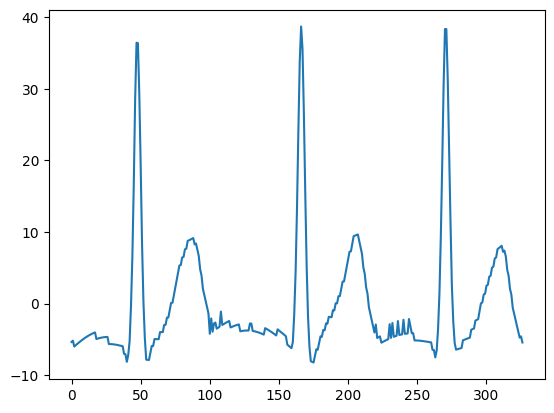

10


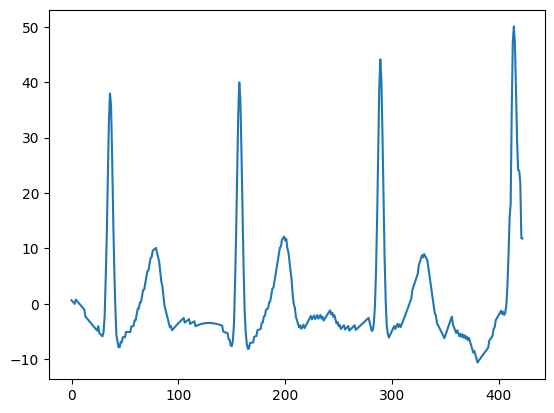

11


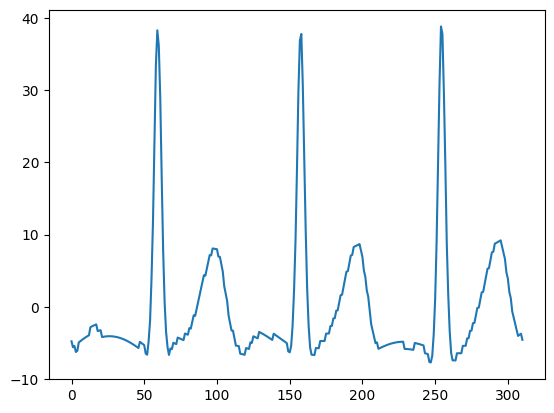

12


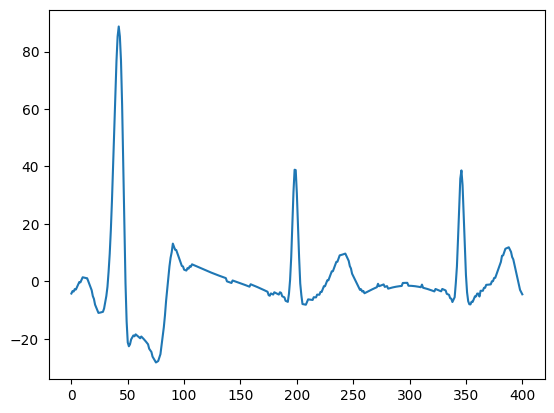

13


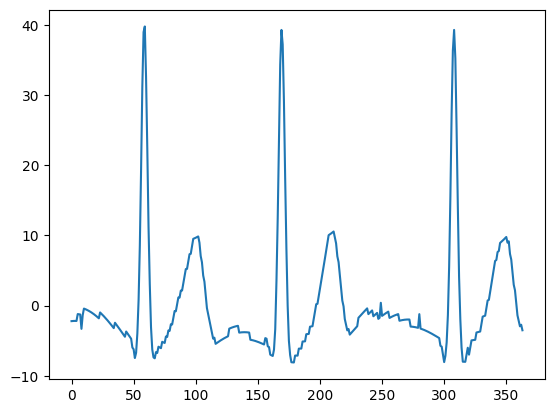

14


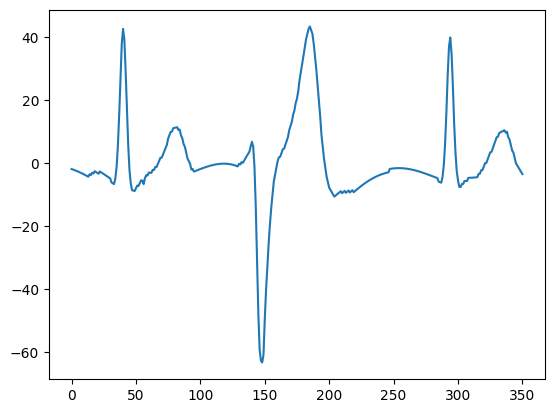

15


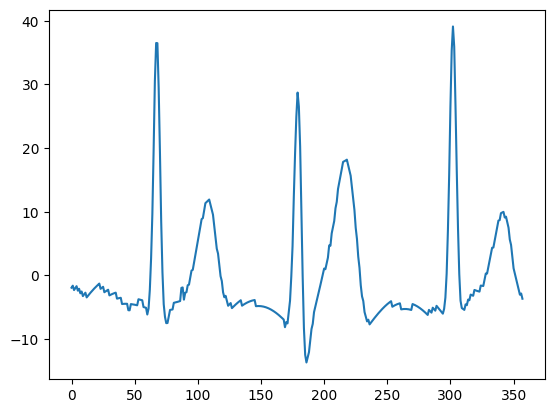

16


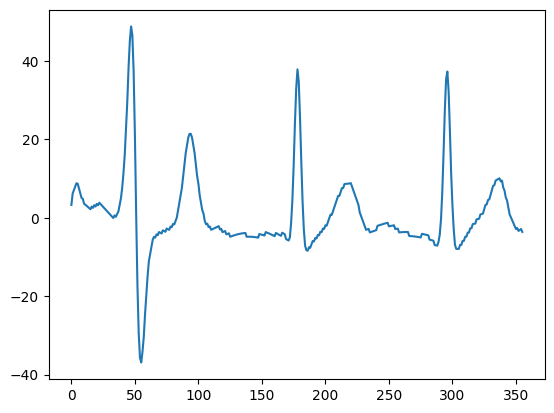

17


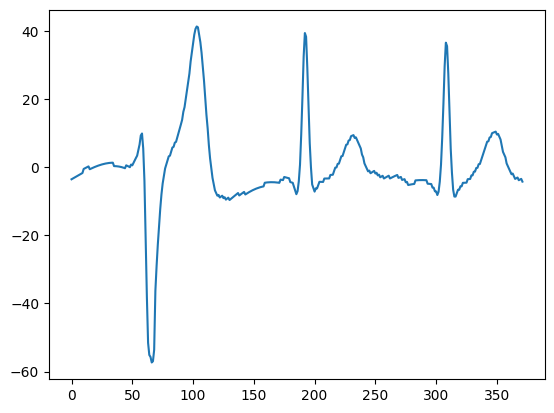

18


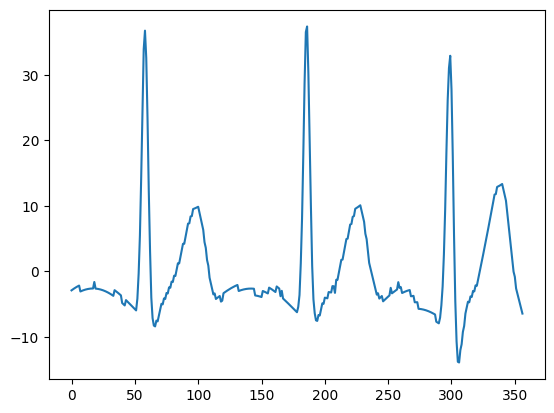

19


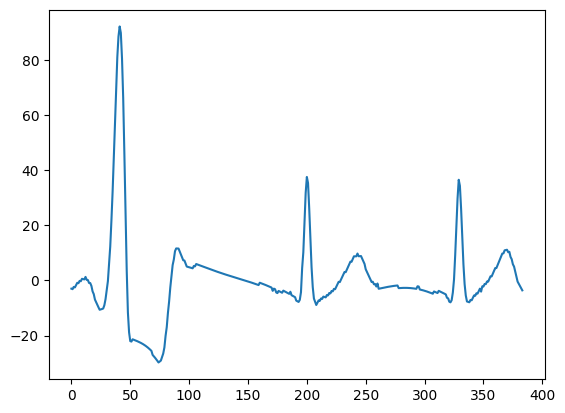

20


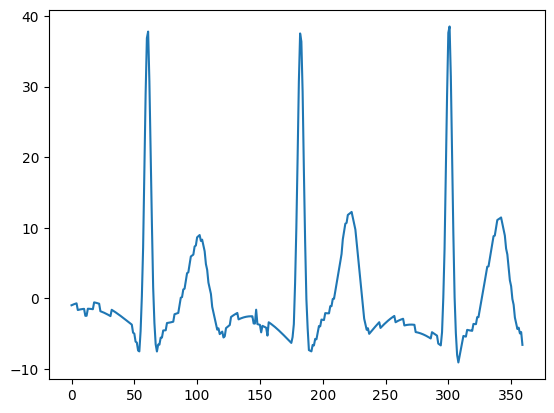

21


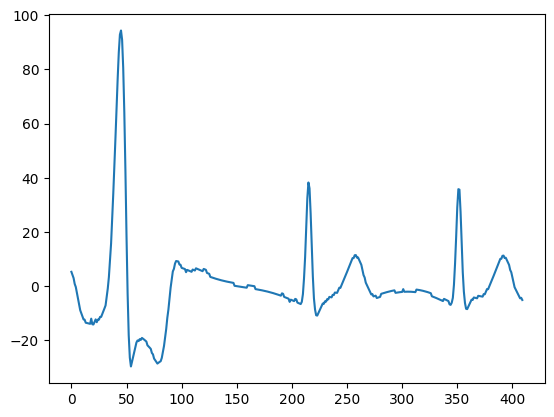

22


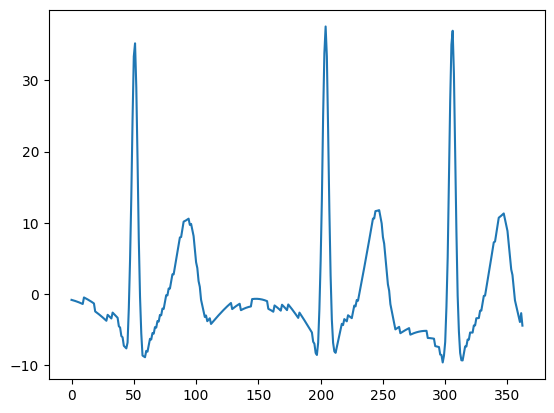

23


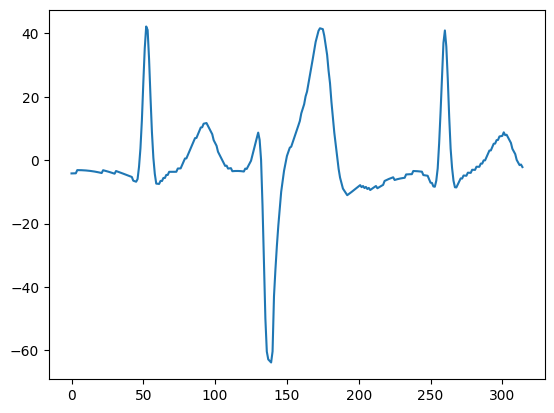

24


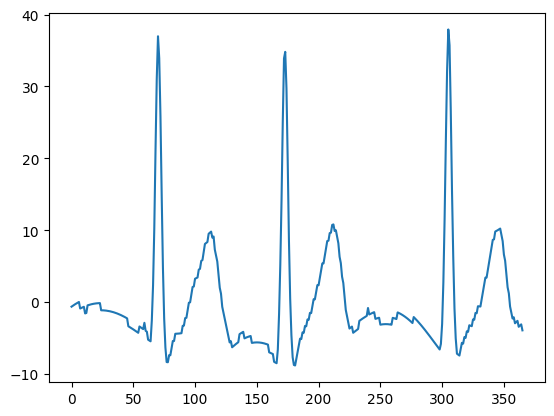

25


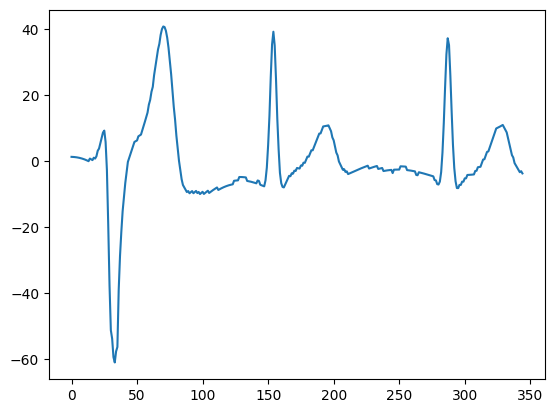

26


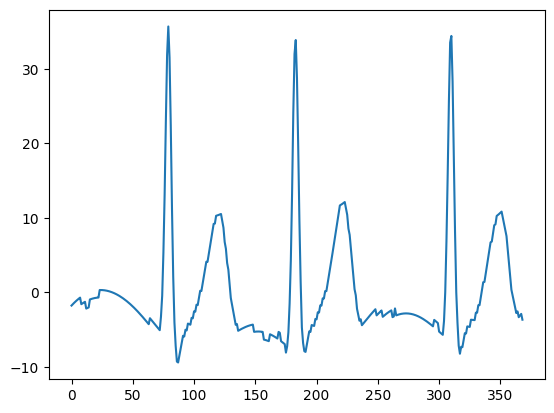

27


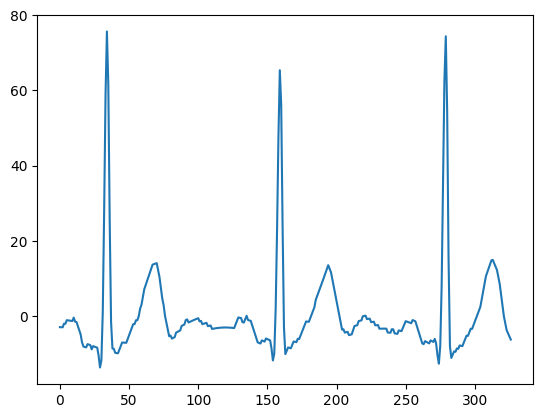

28


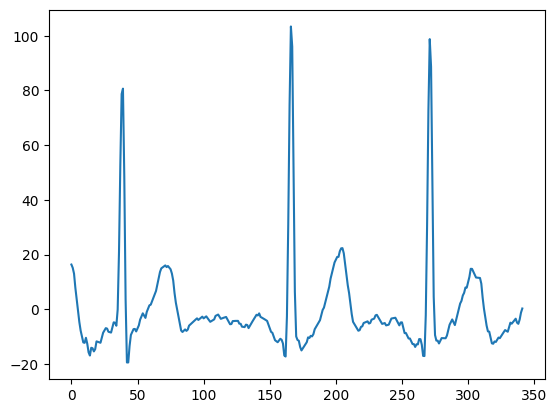

29


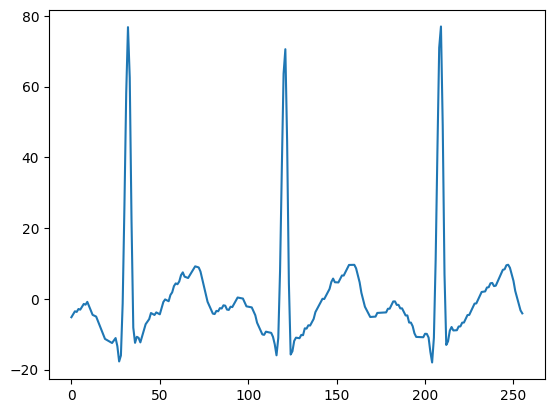

30


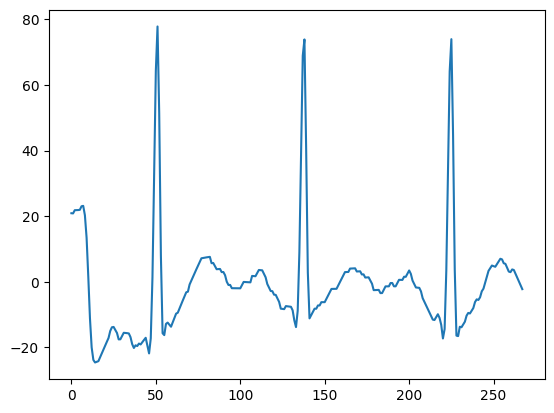

31


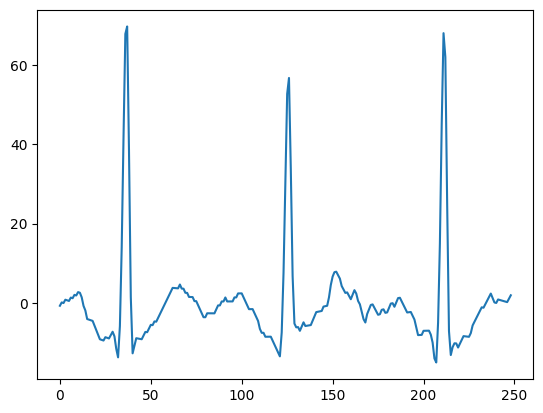

32


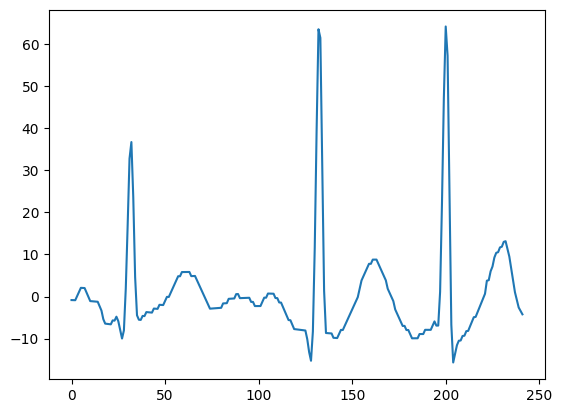

33


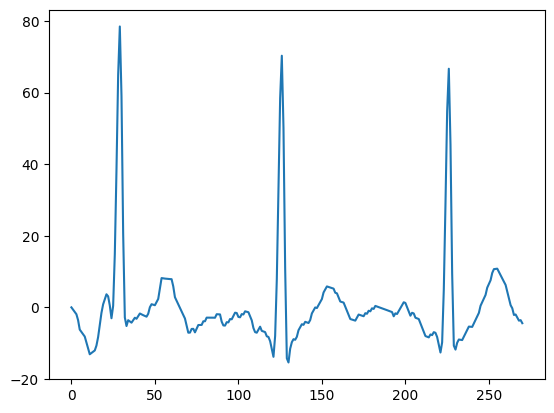

34


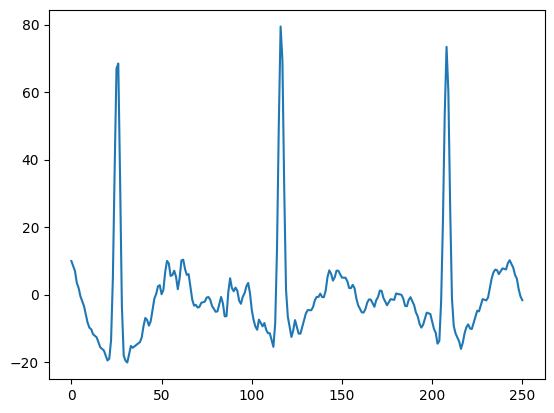

35


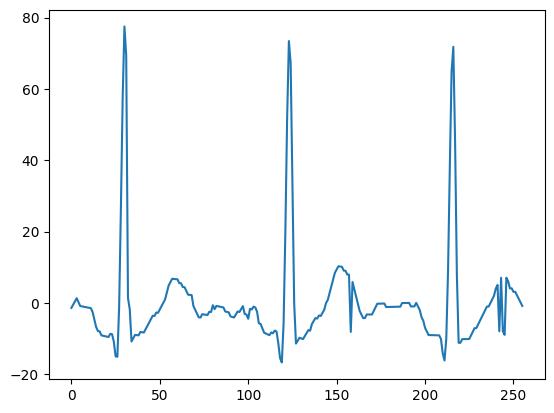

36


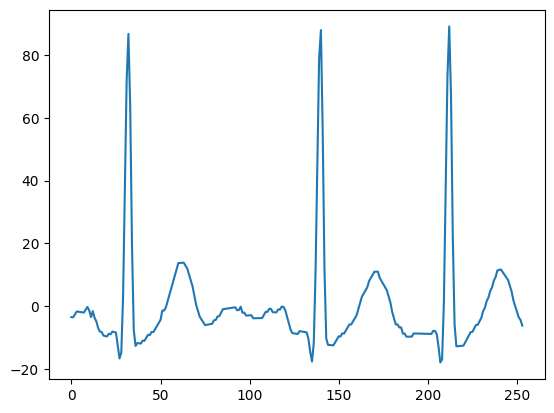

37


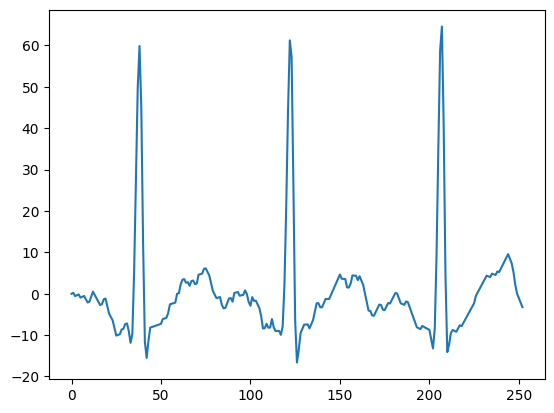

38


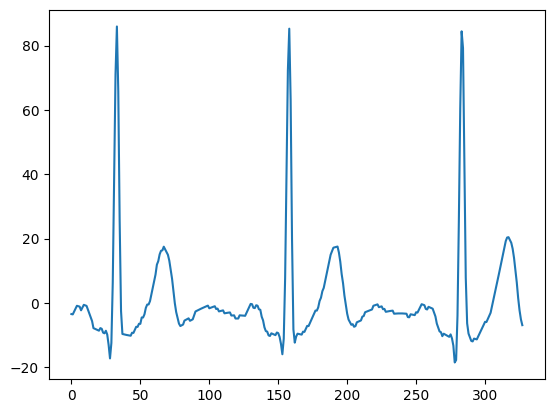

39


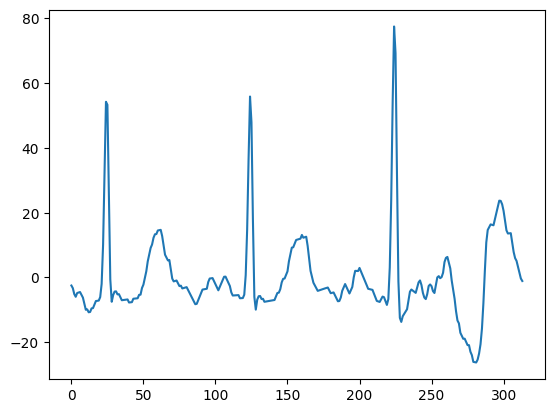

40


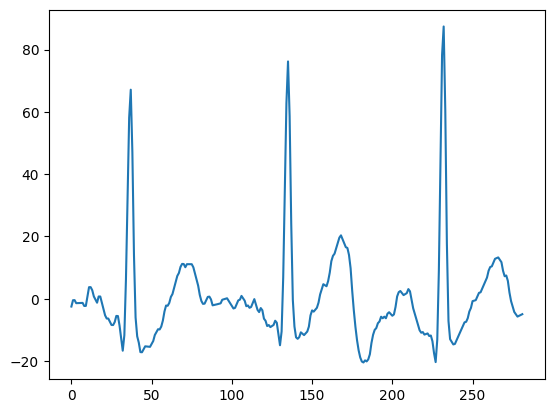

41


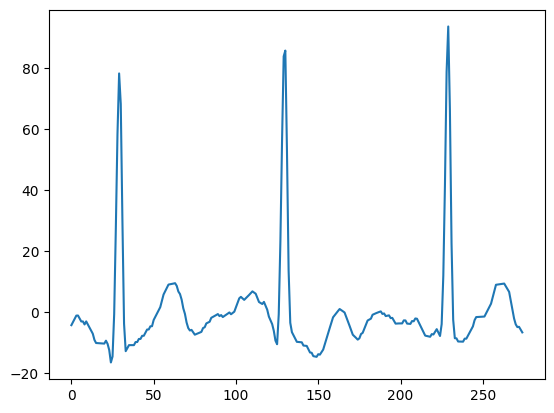

42


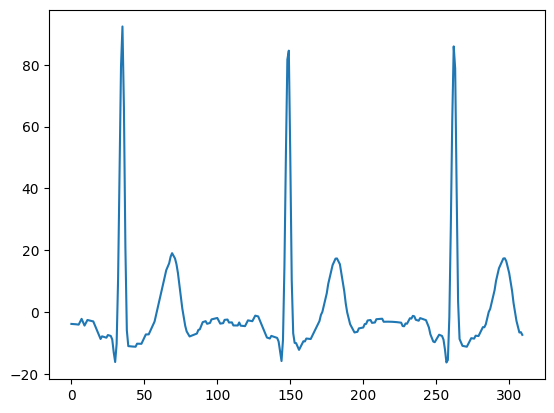

43


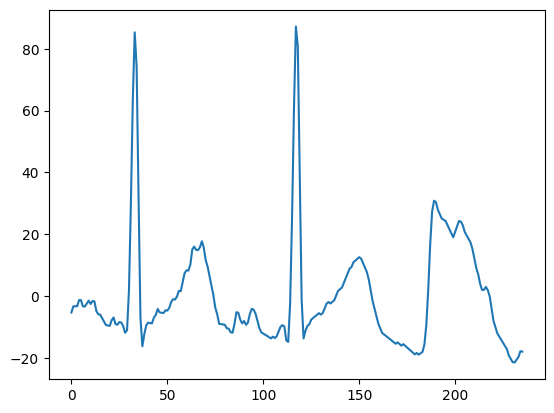

44


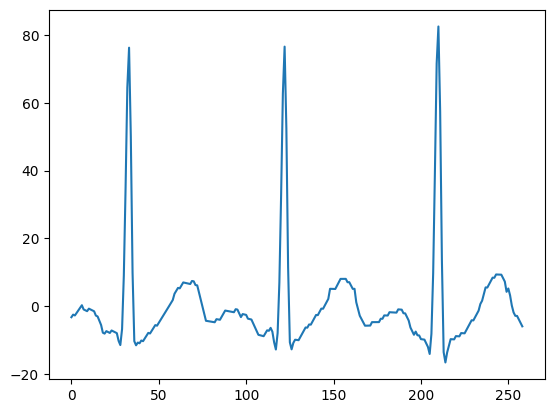

45


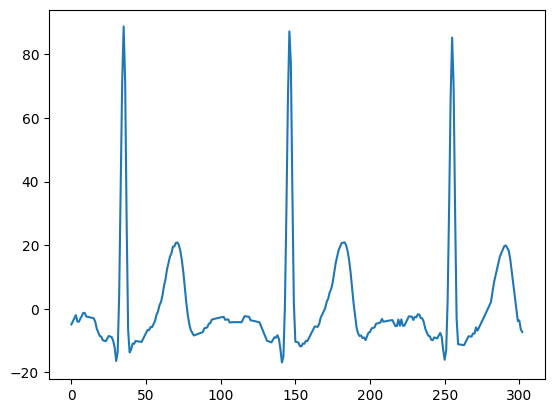

46


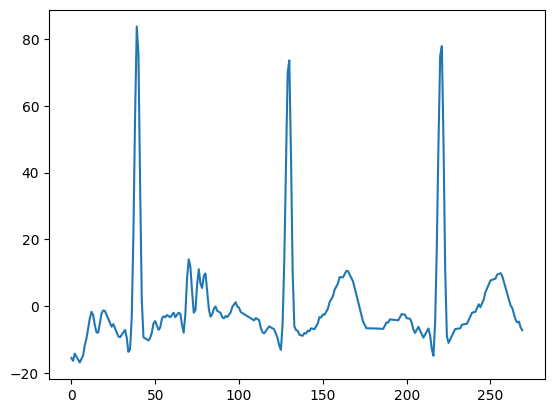

47


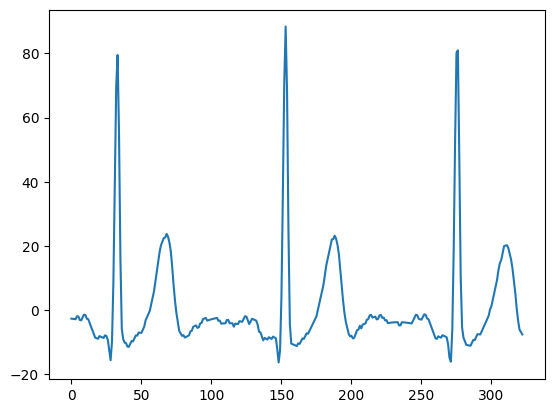

48


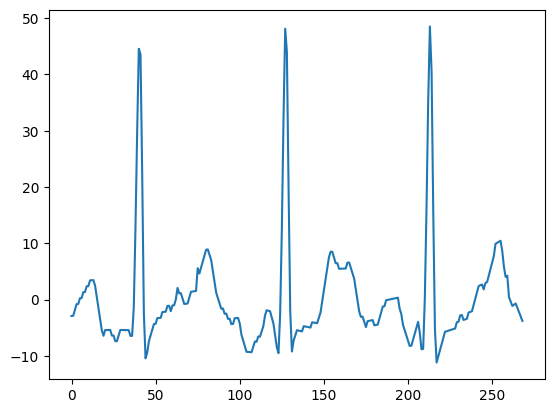

49


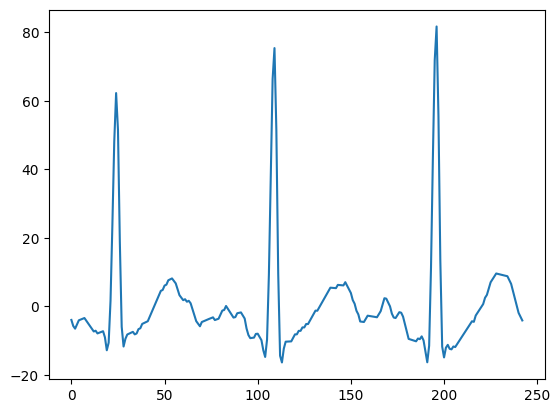

50


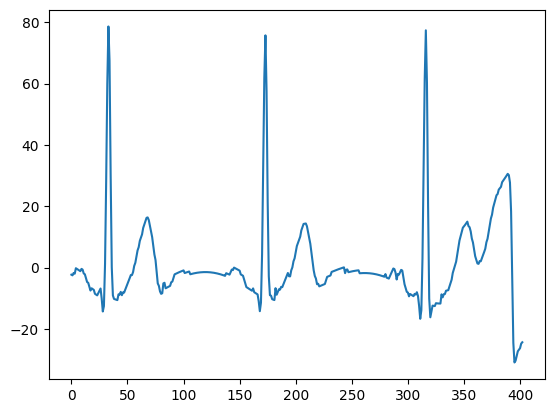

51


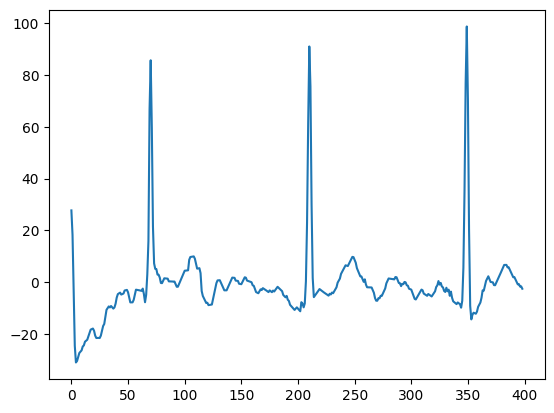

52


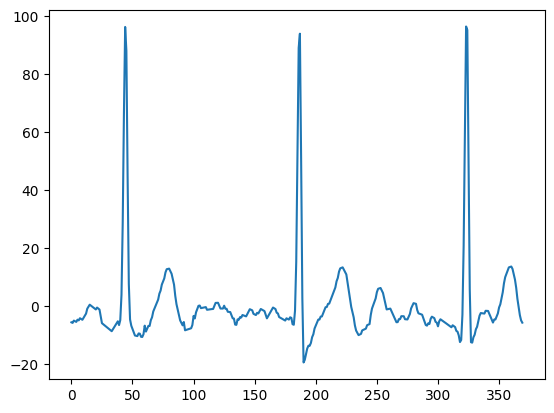

53


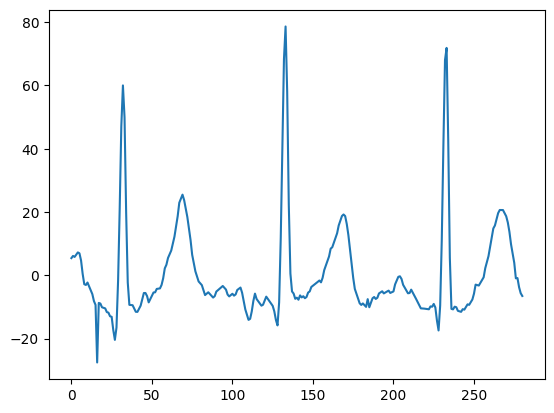

54


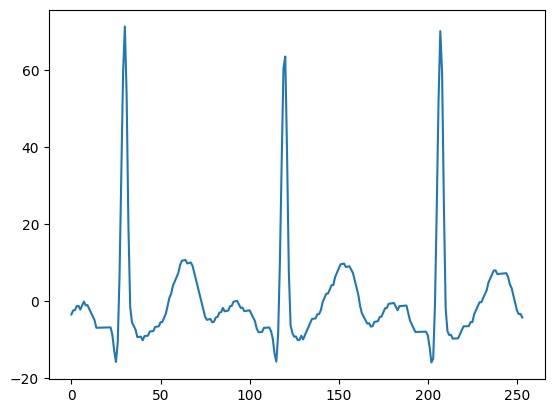

55


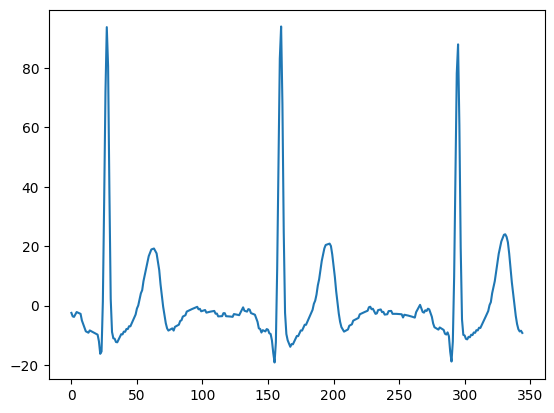

56


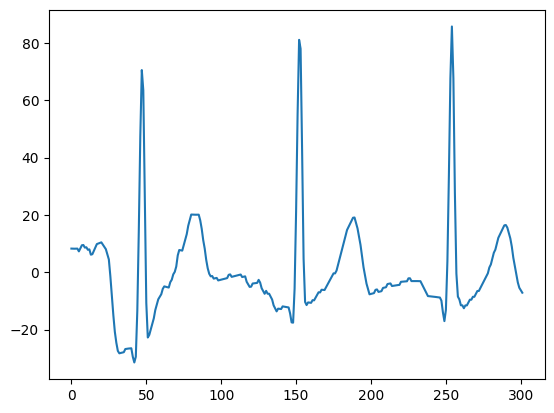

57


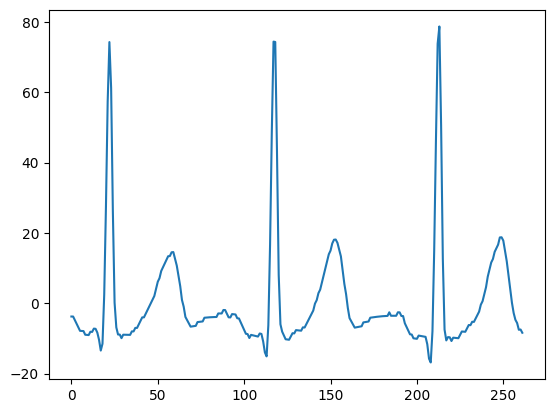

58


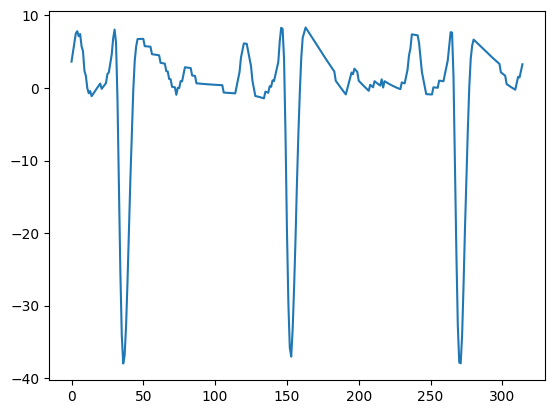

59


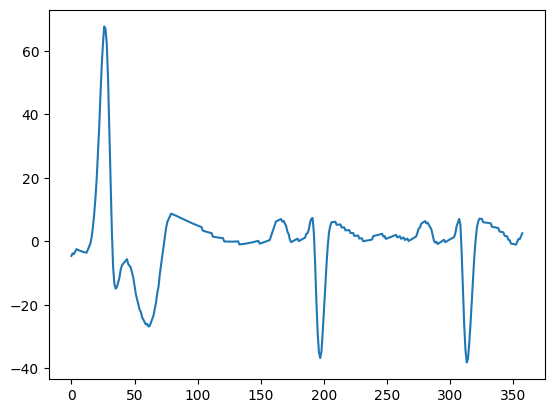

60


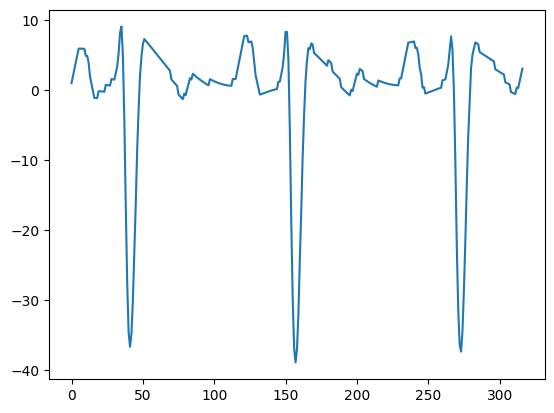

61


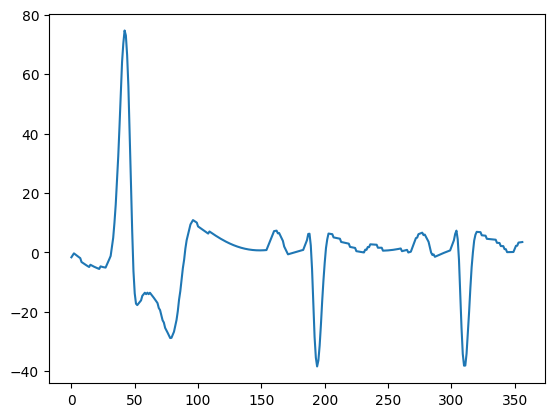

62


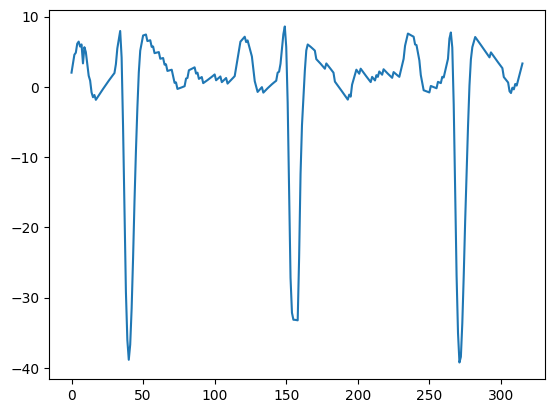

63


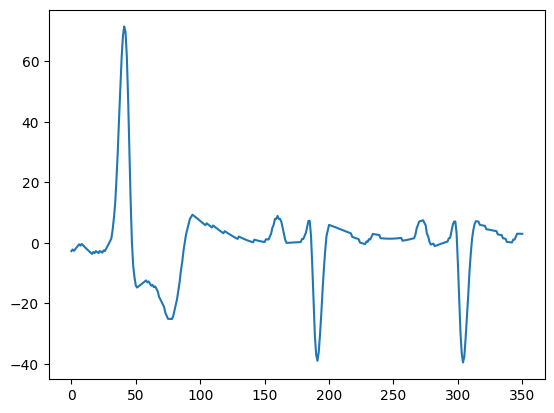

64


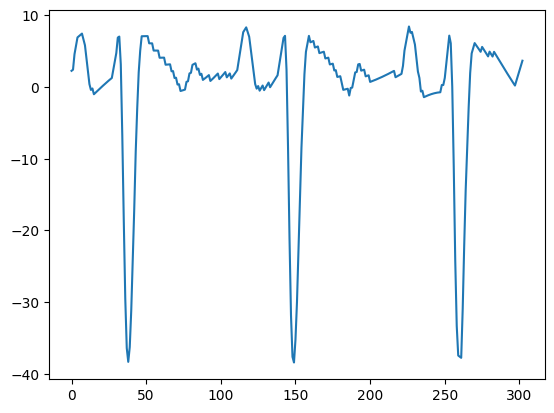

65


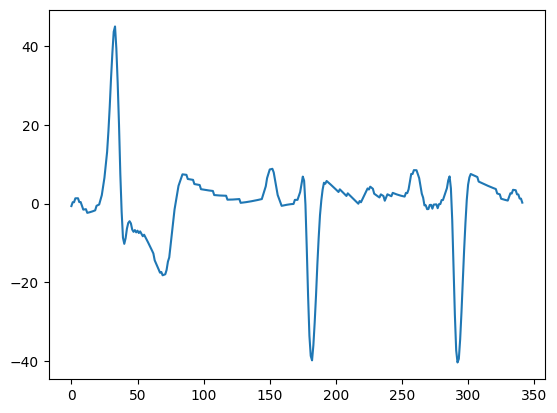

66


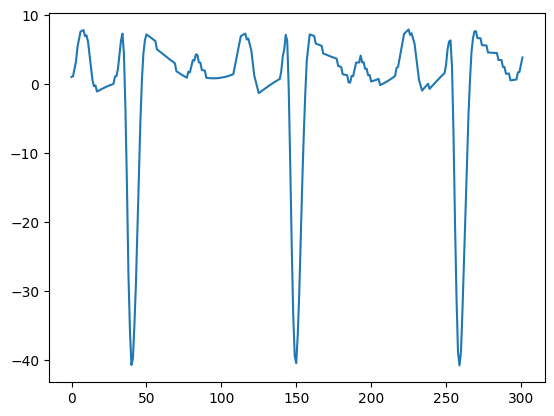

67


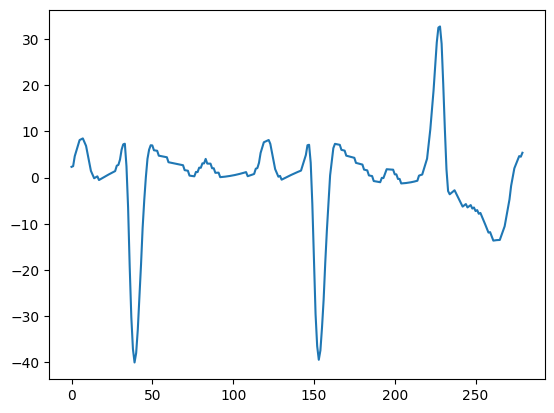

68


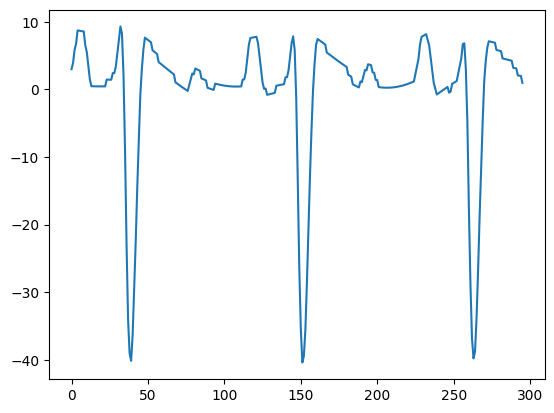

69


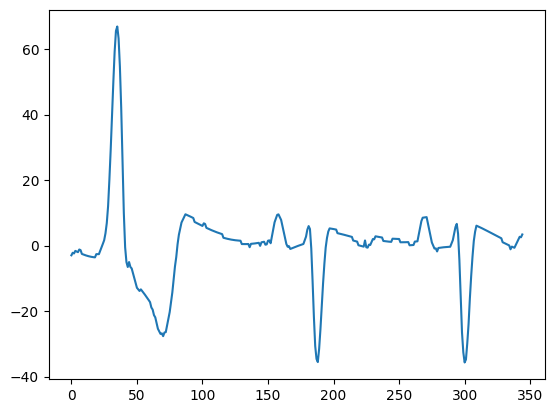

70


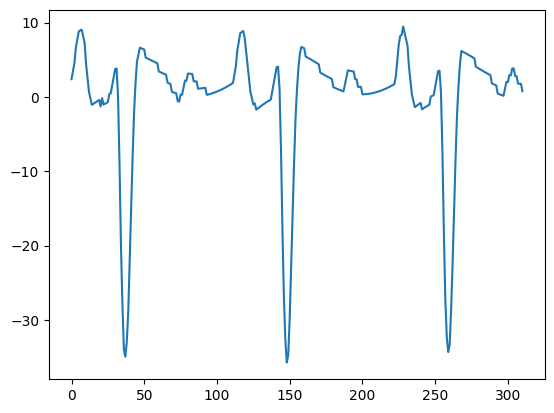

71


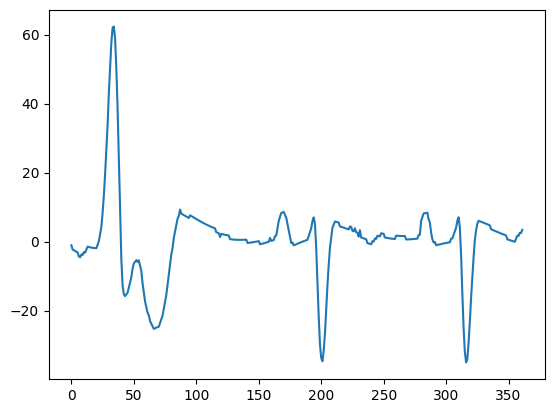

72


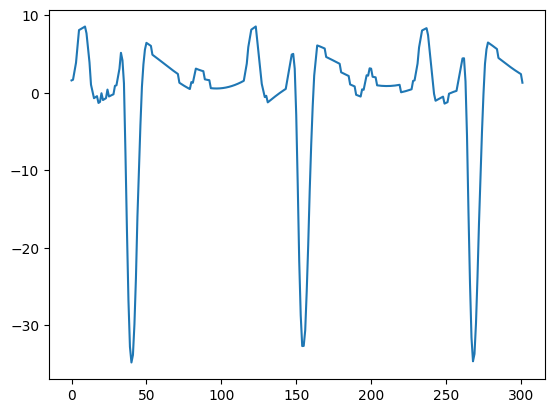

73


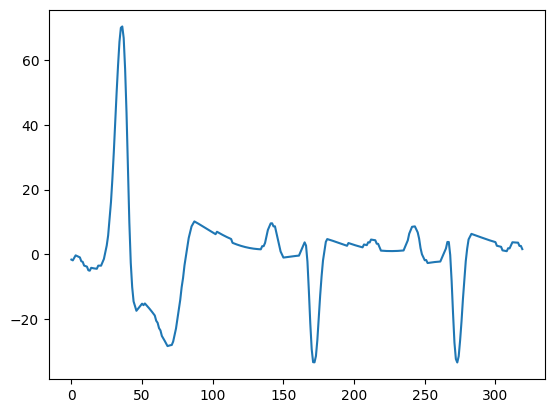

74


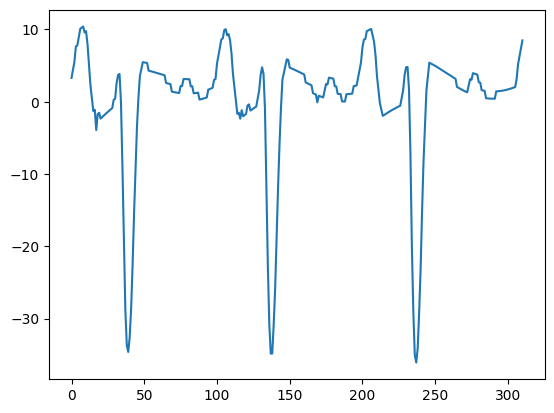

75


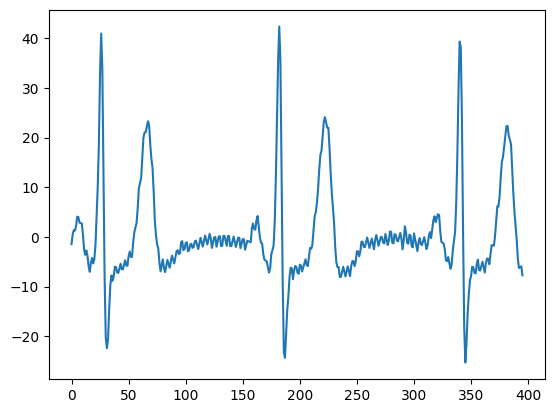

76


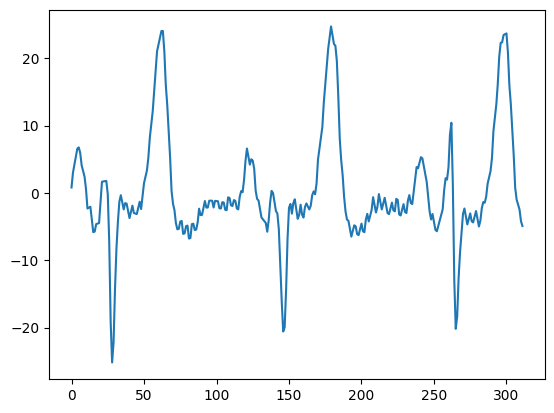

77


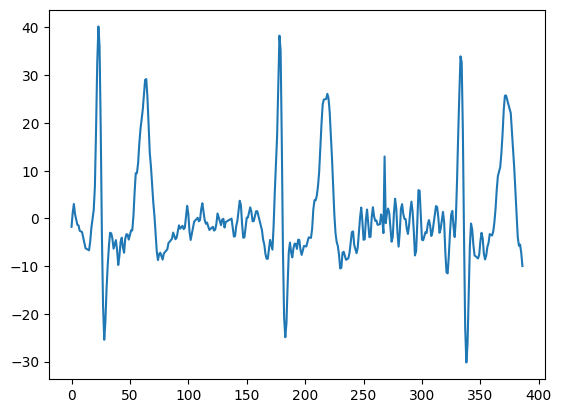

78


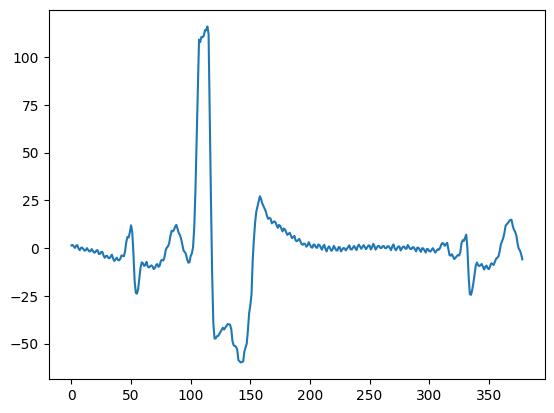

79


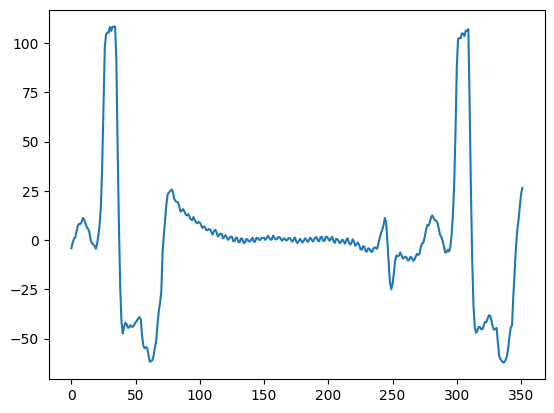

80


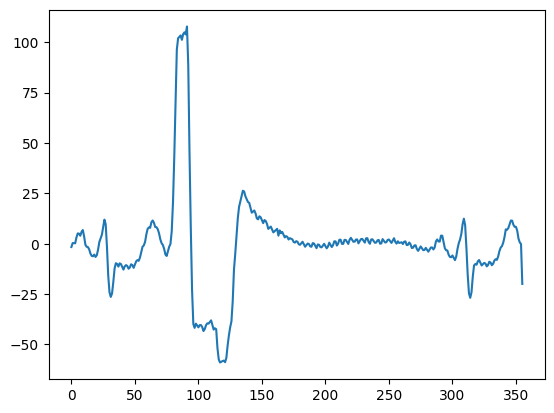

81


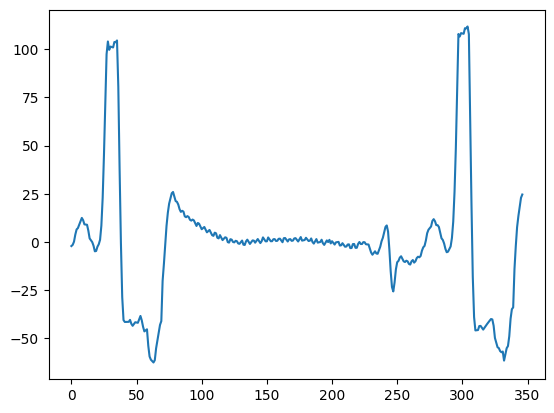

82


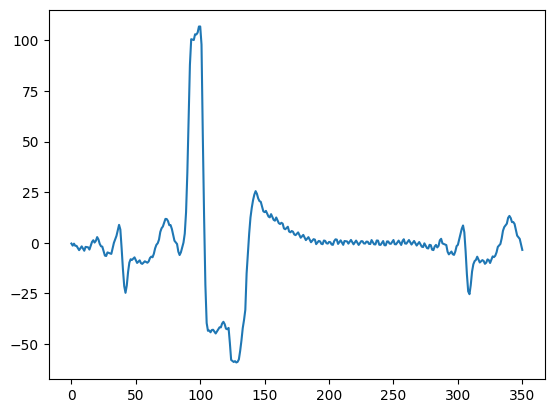

83


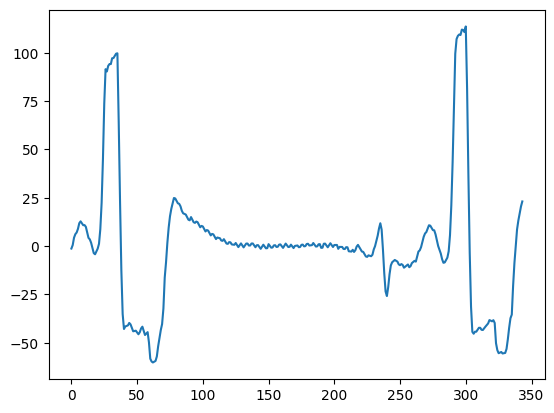

84


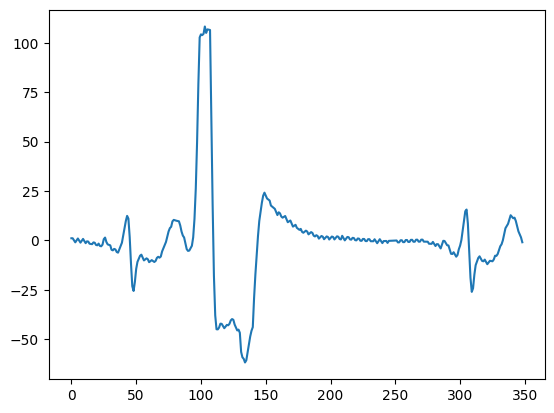

85


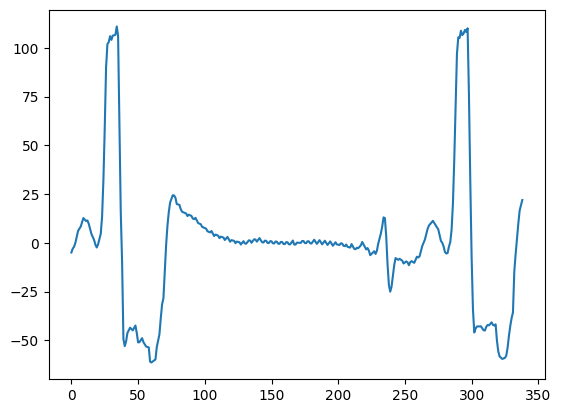

86


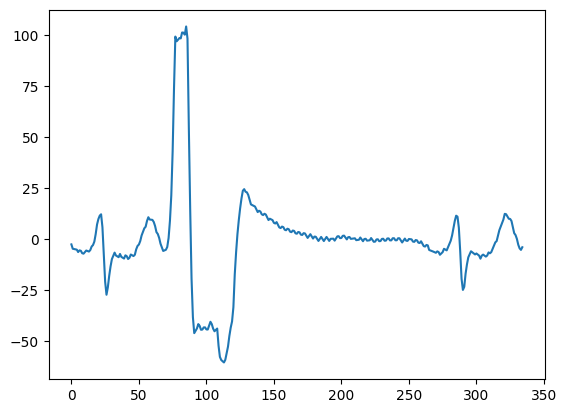

87


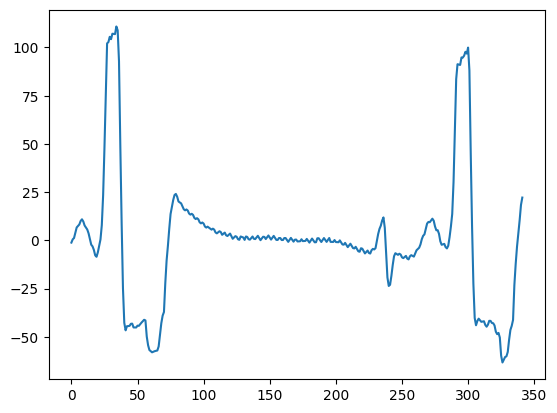

88


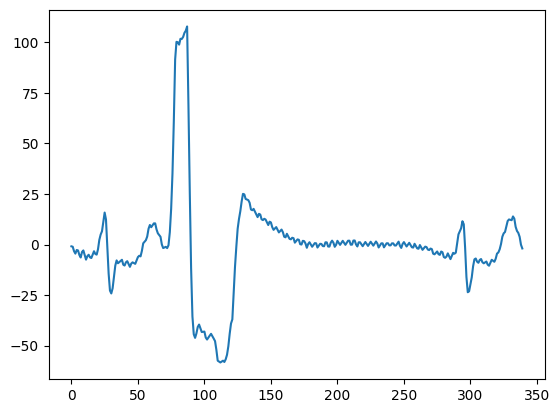

89


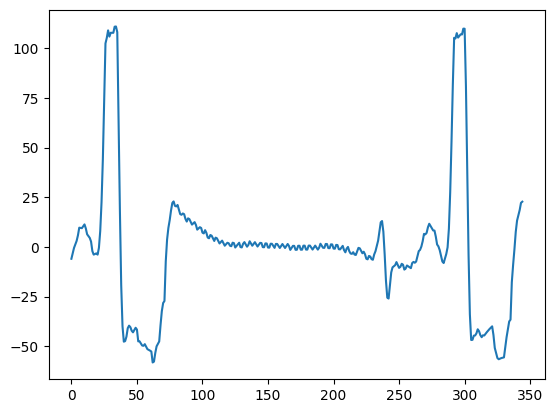

90


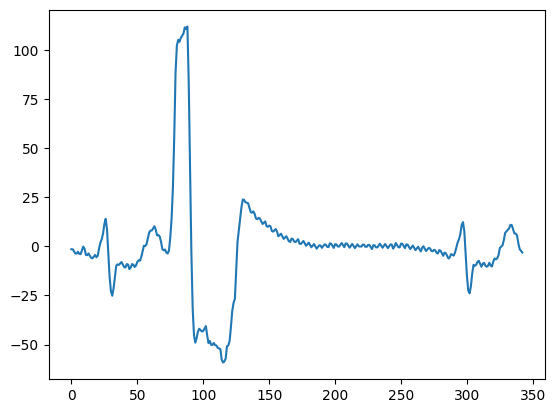

91


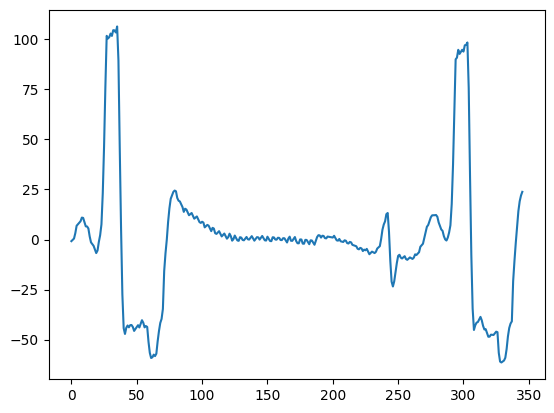

92


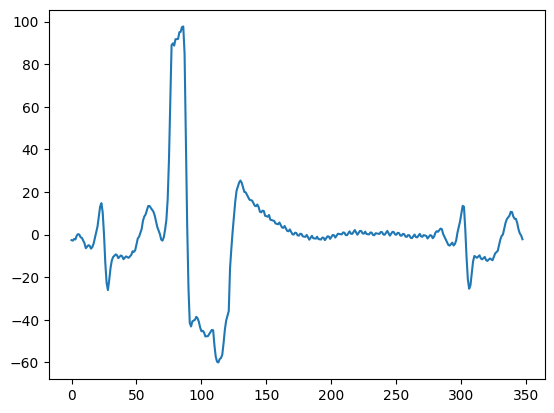

93


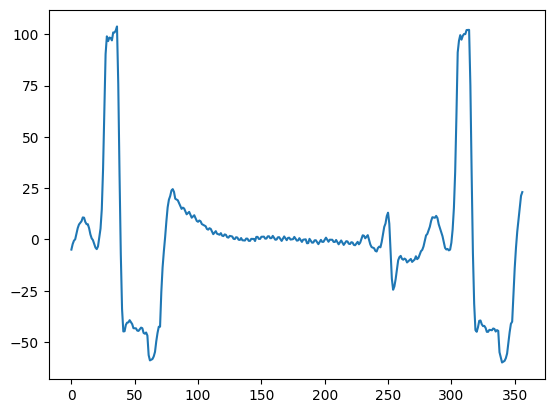

94


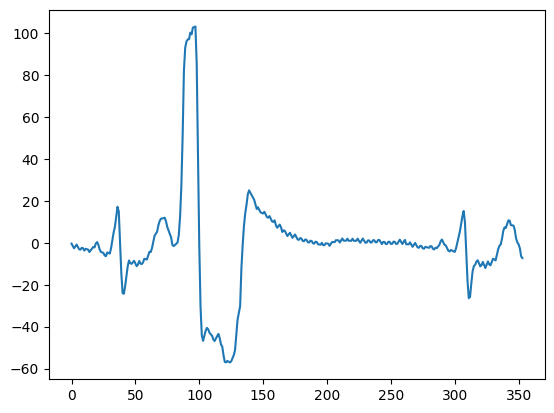

95


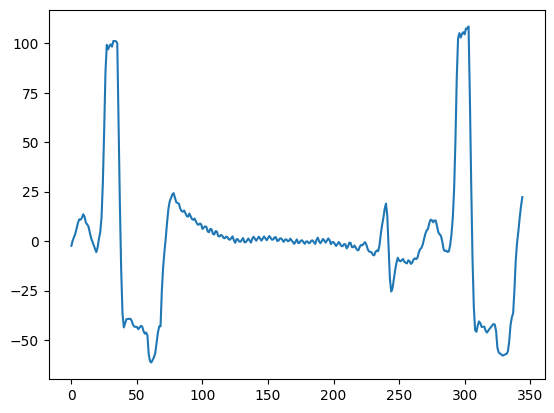

96


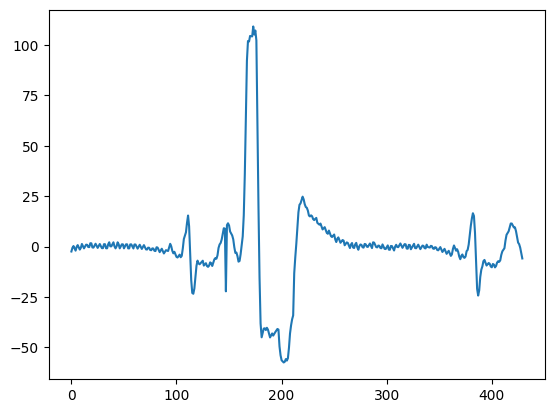

97


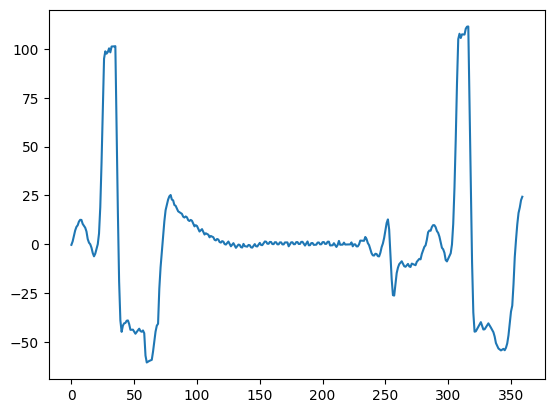

98


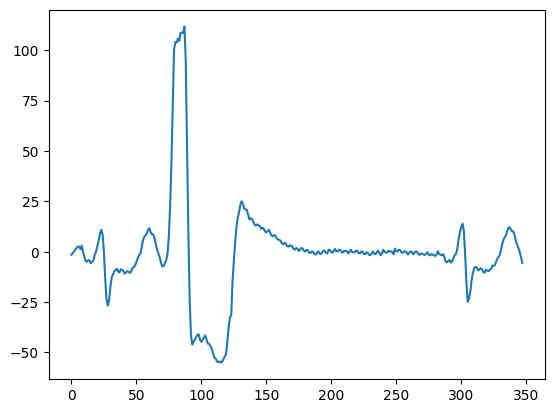

99


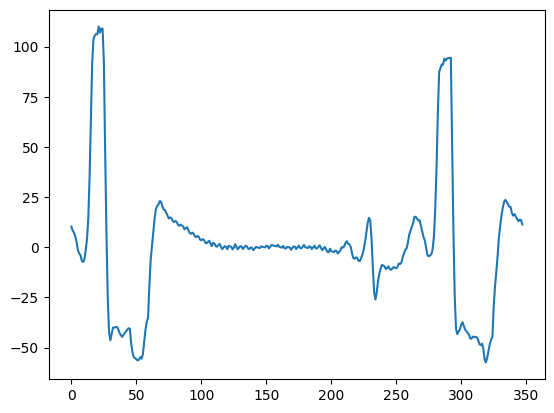

100


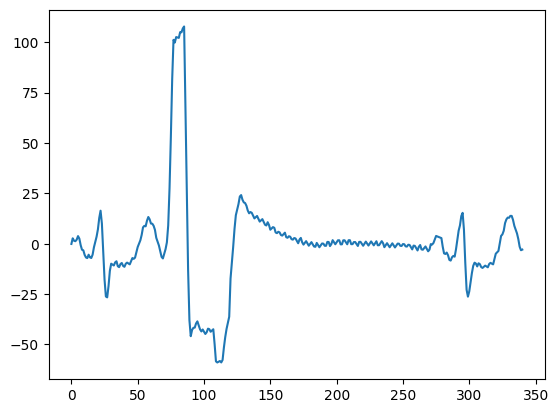

In [40]:
for i, x in enumerate(x_v):
  if i < 100:
    print(i+1)
    plt.plot(x)
    plt.show()

In [84]:
np.save("dataset/x_tr.npy", x_t)
np.save("dataset/x_va.npy", x_v)
np.save("dataset/x_te.npy", x_e)

np.save("dataset/y_tr.npy", y_t)
np.save("dataset/y_va.npy", y_v)
np.save("dataset/y_te.npy", y_e)

In [85]:
run["data"].upload_files("./dataset/*.npy")

In [86]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/gabrie1-s/NACA-data-extraction/e/NAC-22/metadata
